# Sentiment Analysis - Text Classification with Universal Embeddings

Textual data in spite of being highly unstructured, can be classified into two major types of documents. 
- __Factual documents__ which typically depict some form of statements or facts with no specific feelings or emotion attached to them. These are also known as objective documents. 
- __Subjective documents__ on the other hand have text which expresses feelings, mood, emotions and opinion. 

Sentiment Analysis is also popularly known as opinion analysis or opinion mining. The key idea is to use techniques from text analytics, NLP, machine learning and linguistics to extract important information or data points from unstructured text. This in turn can help us derive the sentiment from text data

![](sentiment_cover.png)

Here we will be looking at building supervised sentiment analysis classification models thanks to the advantage of labeled data! The dataset we will be working with is the IMDB Large Movie Review Dataset having 50000 reviews classified into positive and negative sentiment. I have provided a compressed version of the dataset in this repository itself for your benefit!

Do remember that the focus here is not sentiment analysis but text classification by leveraging universal sentence embeddings.

![](sample_classification.png)

We will leverage the following sentence encoders here for demonstration from [TensorFlow Hub](https://tfhub.dev/):

- [__Neural-Net Language Model (nnlm-en-dim128)__](https://tfhub.dev/google/nnlm-en-dim128/1)
- [__Universal Sentence Encoder (universal-sentence-encoder)__](https://tfhub.dev/google/universal-sentence-encoder/2)


_Developed by [Dipanjan (DJ) Sarkar](https://www.linkedin.com/in/dipanzan/)_

# Install Tensorflow Hub

In [1]:
!pip install tensorflow-hub

    100% |################################| 61kB 8.5MB/s ta 0:00:011
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Load up Dependencies

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

# Check if GPU is available for use!

In [12]:
tf.test.is_gpu_available()

True

In [13]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Load and View Dataset

In [14]:
dataset = pd.read_csv('movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [15]:
dataset['sentiment'] = [1 if sentiment == 'positive' else 0 for sentiment in dataset['sentiment'].values]
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Build train, validation and test datasets

In [16]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:30000]
train_sentiments = sentiments[:30000]

val_reviews = reviews[30000:35000]
val_sentiments = sentiments[30000:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]
train_reviews.shape, val_reviews.shape, test_reviews.shape

((30000,), (5000,), (15000,))

# Basic Text Wrangling

In [17]:
!pip install contractions
!pip install beautifulsoup4

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)



def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def pre_process_document(document):
    
    # strip HTML
    document = strip_html_tags(document)
    
    # lower case
    document = document.lower()
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    document = remove_accented_chars(document)
    
    # expand contractions    
    document = expand_contractions(document)
               
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
        
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [19]:
train_reviews = pre_process_corpus(train_reviews)
val_reviews = pre_process_corpus(val_reviews)
test_reviews = pre_process_corpus(test_reviews)

# Build Data Ingestion Functions

In [20]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, 
    batch_size=256, num_epochs=None, shuffle=True)

In [21]:
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, shuffle=False)

In [22]:
# Prediction on the whole validation set.
predict_val_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': val_reviews}, val_sentiments, shuffle=False)

In [23]:
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': test_reviews}, test_sentiments, shuffle=False)

# Build Deep Learning Model with Universal Sentence Encoder

In [15]:
embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [16]:
dnn = tf.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.train.AdagradOptimizer(learning_rate=0.005))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpn9bphscn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f009de6d9b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train for approx 12 epochs

In [1]:
256*1500 / 30000

12.8

# Model Training

In [18]:
tf.logging.set_verbosity(tf.logging.ERROR)
import time

TOTAL_STEPS = 1500
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 78.62789511680603
Eval Metrics (Train): {'accuracy': 0.84863335, 'accuracy_baseline': 0.5005, 'auc': 0.9279859, 'auc_precision_recall': 0.92819566, 'average_loss': 0.34581015, 'label/mean': 0.5005, 'loss': 44.145977, 'precision': 0.86890674, 'prediction/mean': 0.47957155, 'recall': 0.8215118, 'global_step': 100}
Eval Metrics (Validation): {'accuracy': 0.8454, 'accuracy_baseline': 0.505, 'auc': 0.92413086, 'auc_precision_recall': 0.9200026, 'average_loss': 0.35258815, 'label/mean': 0.495, 'loss': 44.073517, 'precision': 0.8522351, 'prediction/mean': 0.48447067, 'recall': 0.8319192, 'global_step': 100}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 76.1651611328125
Eval Metrics (Train): {'accuracy': 0.85436666, 'accuracy_baseline': 0.5005, 'auc': 0.9321357,

Train Time (s): 84.88116145133972
Eval Metrics (Train): {'accuracy': 0.87226665, 'accuracy_baseline': 0.5005, 'auc': 0.94644105, 'auc_precision_recall': 0.94621253, 'average_loss': 0.2976978, 'label/mean': 0.5005, 'loss': 38.00398, 'precision': 0.88602, 'prediction/mean': 0.4845446, 'recall': 0.85474527, 'global_step': 1200}
Eval Metrics (Validation): {'accuracy': 0.8612, 'accuracy_baseline': 0.505, 'auc': 0.9357711, 'auc_precision_recall': 0.93195754, 'average_loss': 0.32375482, 'label/mean': 0.495, 'loss': 40.469353, 'precision': 0.86272913, 'prediction/mean': 0.48821172, 'recall': 0.8557576, 'global_step': 1200}

----------------------------------------------------------------------------------------------------
Training for step = 1200
Train Time (s): 85.49790549278259
Eval Metrics (Train): {'accuracy': 0.8763, 'accuracy_baseline': 0.5005, 'auc': 0.94796634, 'auc_precision_recall': 0.9477355, 'average_loss': 0.29294312, 'label/mean': 0.5005, 'loss': 37.396996, 'precision': 0.873957

# Model Evaluation

In [19]:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.8802,
 'accuracy_baseline': 0.5005,
 'auc': 0.95115364,
 'auc_precision_recall': 0.950775,
 'average_loss': 0.2844779,
 'label/mean': 0.5005,
 'loss': 36.316326,
 'precision': 0.8735527,
 'prediction/mean': 0.51057553,
 'recall': 0.8893773,
 'global_step': 1600}

In [20]:
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.8663333,
 'accuracy_baseline': 0.5006667,
 'auc': 0.9406502,
 'auc_precision_recall': 0.93988097,
 'average_loss': 0.31214723,
 'label/mean': 0.5006667,
 'loss': 39.679733,
 'precision': 0.8597569,
 'prediction/mean': 0.5120608,
 'recall': 0.8758988,
 'global_step': 1600}

# Build a Generic Model Trainer on any Input Sentence Encoder

In [24]:
import time

TOTAL_STEPS = 1500
STEP_SIZE = 500

my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 2,       # Retain the 2 most recent checkpoints.
)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec=hub_module, trainable=train_module)
  
    print()
    print('='*100)
    print('Training with', hub_module)
    print('Trainable is:', train_module)
    print('='*100)
  
    dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=path,
            config=my_checkpointing_config)

    for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
        print('-'*100)
        print('Training for step =', step)
        start_time = time.time()
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        elapsed_time = time.time() - start_time
        print('Train Time (s):', elapsed_time)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

    train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)

    return {
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    }

# Train Deep Learning Models on difference Sentence Encoders
- NNLM - pre-trained and fine-tuning
- USE - pre-trained and fine-tuning

In [25]:
tf.logging.set_verbosity(tf.logging.ERROR)

results = {}

results["nnlm-en-dim128"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", path='/storage/models/nnlm-en-dim128_f/')

results["nnlm-en-dim128-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", train_module=True, path='/storage/models/nnlm-en-dim128_t/')

results["use-512"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", path='/storage/models/use-512_f/')

results["use-512-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", train_module=True, path='/storage/models/use-512_t/')


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: False
----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 30.525171756744385
Eval Metrics (Train): {'accuracy': 0.8480667, 'accuracy_baseline': 0.5005, 'auc': 0.9287864, 'auc_precision_recall': 0.9287345, 'average_loss': 0.34465897, 'label/mean': 0.5005, 'loss': 43.99902, 'precision': 0.8288572, 'prediction/mean': 0.5302467, 'recall': 0.8776557, 'global_step': 2500}
Eval Metrics (Validation): {'accuracy': 0.8288, 'accuracy_baseline': 0.505, 'auc': 0.91452694, 'auc_precision_recall': 0.9113482, 'average_loss': 0.37722248, 'label/mean': 0.495, 'loss': 47.15281, 'precision': 0.7999259, 'prediction/mean': 0.53336626, 'recall': 0.8723232, 'global_step': 2500}
----------------------------------------------------------------------------------------------------
Training for step = 500
Train Time (s): 27.883334159851074
Eval Metrics (Train

Train Time (s): 258.70958161354065
Eval Metrics (Train): {'accuracy': 0.8782333, 'accuracy_baseline': 0.5005, 'auc': 0.9505533, 'auc_precision_recall': 0.94987434, 'average_loss': 0.28575605, 'label/mean': 0.5005, 'loss': 36.479496, 'precision': 0.8756281, 'prediction/mean': 0.5043332, 'recall': 0.8819847, 'global_step': 1501}
Eval Metrics (Validation): {'accuracy': 0.8616, 'accuracy_baseline': 0.505, 'auc': 0.9369738, 'auc_precision_recall': 0.9333807, 'average_loss': 0.32096896, 'label/mean': 0.495, 'loss': 40.121117, 'precision': 0.8505702, 'prediction/mean': 0.5080113, 'recall': 0.8739394, 'global_step': 1501}
----------------------------------------------------------------------------------------------------
Training for step = 1500
Train Time (s): 258.4421606063843
Eval Metrics (Train): {'accuracy': 0.88733333, 'accuracy_baseline': 0.5005, 'auc': 0.9558296, 'auc_precision_recall': 0.95508415, 'average_loss': 0.2716801, 'label/mean': 0.5005, 'loss': 34.682564, 'precision': 0.89799

# Model Evaluations

In [27]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,Model Dir,Training Accuracy,Test Accuracy,Training AUC,Test AUC,Training Precision,Test Precision,Training Recall,Test Recall
nnlm-en-dim128,/storage/models/nnlm-en-dim128_f/,0.861600,0.836133,0.938546,0.918221,0.844354,0.822770,0.886980,0.857390
nnlm-en-dim128-with-training,/storage/models/nnlm-en-dim128_t/,1.000000,0.878467,1.000000,0.919655,1.000000,0.875975,1.000000,0.882157
use-512,/storage/models/use-512_f/,0.887333,0.867067,0.955830,0.942319,0.897995,0.876776,0.874192,0.854594
use-512-with-training,/storage/models/use-512_t/,1.000000,0.904533,1.000000,0.930401,1.000000,0.904660,1.000000,0.904660


In [54]:
best_model_dir = results_df[results_df['Test Accuracy'] == results_df['Test Accuracy'].max()]['Model Dir'].values[0]
best_model_dir

'/storage/models/use-512_t/'

In [55]:
embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec="https://tfhub.dev/google/universal-sentence-encoder/2", trainable=True)

dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=best_model_dir)
dnn

In [56]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [57]:
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1]

In [58]:
!pip install seaborn

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


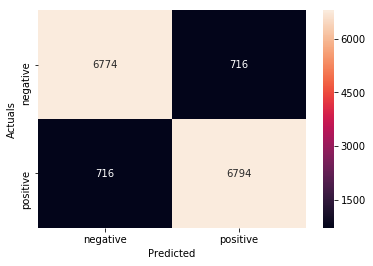

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_sentiments, predictions).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_sentiments, y_pred=predictions, target_names=LABELS))

             precision    recall  f1-score   support

   negative       0.90      0.90      0.90      7490
   positive       0.90      0.90      0.90      7510

avg / total       0.90      0.90      0.90     15000

